# FEE

## PMT front end electronics

In [1]:
from __future__ import print_function
%matplotlib inline
%load_ext autoreload
%autoreload 2
%load_ext Cython
%matplotlib inline
%load_ext line_profiler

In [2]:
import pandas as pd
import numpy as np
from time import time
import matplotlib.pyplot as plt

In [3]:
import tables

In [4]:
from LogConfig import *

In [5]:
import cProfile

In [6]:
import mplFunctions as mpl

In [7]:
from Util import *
from scipy import signal as SGN

In [25]:
import FEE2 as FE

In [28]:
def single_pe(start_pulse=100*ns, end_pulse=500*ns, noise=FP.NOISE_FEE_rms):
    spe = SP.SPE()
    
    C12 = np.array([ 6.02975448,  6.22547194,  6.0671337 ,  6.22159457,  6.29999787,
        6.09892384,  6.18289435,  6.21775591,  6.19306671,  6.30518792,
        6.20359891,  6.31231192])*nF
    
    cc = []
    plot = True
    for C in C12:
        fee = FE.FEE(PMTG=FP.PMT_GAIN, C=C,R= FP.R, f=FP.freq_LPF, RG=FP.V_GAIN)
        # PMT response to a single photon (single pe current pulse)
        signal_t, signal_PE =spe.SpePulse(start_pulse, tmax=end_pulse)
        # spe in voltage (without FEE)
        signal_PE_v = fee.VSignal(signal_PE)
        # effect of FEE
        signal_fee, signal_blr = fee.FEESignal(signal_PE, noise_rms=noise)
        # effect of DAQ
        signal_t_daq, signal_daq = fee.DAQSignal(signal_t, signal_fee, noise_rms=0)
        
        if plot == True:
            plt.figure(figsize=(12,12))

            ax1 = plt.subplot(2,2,1)
            ax1.set_xlim([0, len(signal_t)])
            mpl.SetPlotLabels(xlabel='t (ns)', ylabel='spe (muA)')
            plt.plot(signal_t, signal_PE/muA)

            ax2 = plt.subplot(2,2,2)
            ax2.set_xlim([0, len(signal_t)])
            mpl.SetPlotLabels(xlabel='t (ns)', ylabel='spe (mV)')
            plt.plot(signal_t, signal_PE_v/mV)

            ax3 = plt.subplot(2,2,3)
            ax3.set_xlim([0, len(signal_t)])
            mpl.SetPlotLabels(xlabel='t (ns)', ylabel='spe+FEE (mV)')
            plt.plot(signal_t, signal_fee/mV)

            ax4 = plt.subplot(2,2,4)
            ax4.set_xlim([0, len(signal_t)])
            mpl.SetPlotLabels(xlabel='t (ns)', ylabel='spe+FEE+DAQ (adc)')
            plt.plot(signal_t_daq, signal_daq)
            plt.show()
            wait()
            plot = False

        area = np.sum(signal_daq)
        print("adc counts per spe = {}".format(area))
        cc.append(area)

    return cc

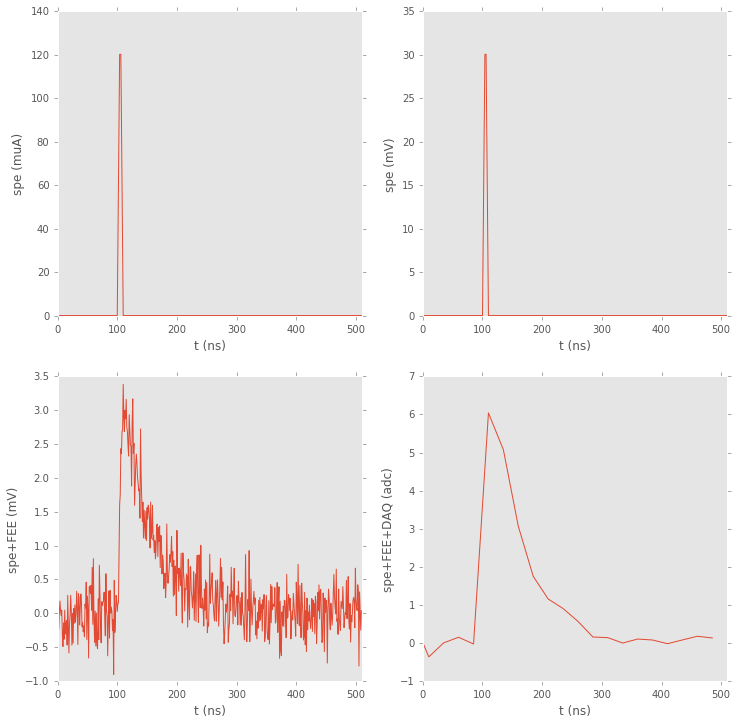

Press a key...
adc counts per spe = 19.070290494
adc counts per spe = 18.3125111109
adc counts per spe = 18.7024519528
adc counts per spe = 18.9729552228
adc counts per spe = 19.8755897606
adc counts per spe = 17.6842140032
adc counts per spe = 19.5276243481
adc counts per spe = 17.2071983986
adc counts per spe = 18.2658220113
adc counts per spe = 19.4686723373
adc counts per spe = 18.167621659
adc counts per spe = 19.663796083


In [29]:
cc = single_pe()

In [16]:
cc

[19.200523269821286,
 18.337220349094959,
 18.277890643055709,
 20.094008664586799,
 19.623449041069801,
 18.267600383584281,
 19.062919010617382,
 17.392029016798073,
 18.334949819343084,
 18.462968438179974,
 18.634919155741205,
 18.112776381185306]

In [32]:
def calibration_constants_from_spe(start_pulse=100*ns, end_pulse=500*ns,
                                  noise=FP.NOISE_FEE_rms):
    """
    Computes calibration constants from the are of a SPE
    """
    spe = SP.SPE()
    cc = []

    for pmt, C in enumerate(FP.C12):
        fee = FE.FEE(PMTG=FP.PMT_GAIN, C=C,R= FP.R, f=FP.freq_LPF, RG=FP.V_GAIN)
        # PMT response to a single photon (single pe current pulse)
        signal_t, signal_PE =spe.SpePulse(start_pulse, tmax=end_pulse)
        # spe in voltage (without FEE)
        signal_PE_v = fee.VSignal(signal_PE)
        # effect of FEE
        signal_fee, signal_blr = fee.FEESignal(signal_PE,
                                               noise_rms=FP.NOISE_FEE)
        
        # effect of DAQ
        signal_daq = fee.daqSignal(signal_fee, noise_rms=0)
        signal_daq_blr = fee.daqSignal(signal_blr, noise_rms=0)
        area = np.sum(signal_daq)
        area_blr = np.sum(signal_daq_blr)
        print("PMT = {}: cc = {}, cc blr = {}".format( pmt, area, area_blr))
        cc.append(area)

    return cc

In [33]:
calibration_constants_from_spe()

PMT = 0: cc = 19.202385104, cc blr = 19.6391443628
PMT = 1: cc = 18.1303001452, cc blr = 18.5534909882
PMT = 2: cc = 17.958281769, cc blr = 18.3923828509
PMT = 3: cc = 17.4394106515, cc blr = 17.8628621093
PMT = 4: cc = 19.6907769479, cc blr = 20.10902019
PMT = 5: cc = 17.888113407, cc blr = 18.3199791009
PMT = 6: cc = 17.8999235978, cc blr = 18.3259939626
PMT = 7: cc = 18.7484668118, cc blr = 19.1721765988
PMT = 8: cc = 17.248056288, cc blr = 17.6734351395
PMT = 9: cc = 18.2803984384, cc blr = 18.6983014304
PMT = 10: cc = 18.2254408007, cc blr = 18.6501060381
PMT = 11: cc = 17.5631868473, cc blr = 17.9806237034


[19.202385103961323,
 18.1303001451931,
 17.958281768963268,
 17.439410651500509,
 19.690776947902968,
 17.888113406975872,
 17.899923597797862,
 18.748466811812289,
 17.24805628804549,
 18.280398438435064,
 18.225440800666121,
 17.563186847327259]

In [28]:
def single_pe_blr(start_pulse=100*ns, end_pulse=500*ns, noise=FP.NOISE_FEE_rms):
    spe = SP.SPE()
    fee = FEE()
    # PMT response to a single photon (single pe current pulse)
    signal_t, signal_PE =spe.SpePulse(start_pulse, tmax=end_pulse)
    # spe in voltage (without FEE)
    signal_PE_v = fee.VSignal(signal_PE)
    #effect of FEE
    signal_fee = fee.BLRSignal(signal_PE, noise_rms=noise)
    #effect of DAQ
    signal_t_daq, signal_daq = fee.DAQSignal(signal_t, signal_fee, noise_rms=0)
    #signal_daq *=FP.time_DAQ #re-scale by decimation factor
    plt.figure(figsize=(12,12))

    ax1 = plt.subplot(2,2,1)
    ax1.set_xlim([0, len(signal_t)])
    mpl.SetPlotLabels(xlabel='t (ns)', ylabel='spe (muA)')
    plt.plot(signal_t, signal_PE/muA)

    ax2 = plt.subplot(2,2,2)
    ax2.set_xlim([0, len(signal_t)])
    mpl.SetPlotLabels(xlabel='t (ns)', ylabel='spe (mV)')
    plt.plot(signal_t, signal_PE_v/mV)

    ax3 = plt.subplot(2,2,3)
    ax3.set_xlim([0, len(signal_t)])
    mpl.SetPlotLabels(xlabel='t (ns)', ylabel='spe+FEE (mV)')
    plt.plot(signal_t, signal_fee/mV)

    ax4 = plt.subplot(2,2,4)
    ax4.set_xlim([0, len(signal_t)])
    mpl.SetPlotLabels(xlabel='t (ns)', ylabel='spe+FEE+DAQ (adc)')
    plt.plot(signal_t_daq, signal_daq)

    area = np.sum(signal_daq)
    print("adc counts per spe = {}".format(area))

    plt.show()

adc counts per spe = 19.7030253964


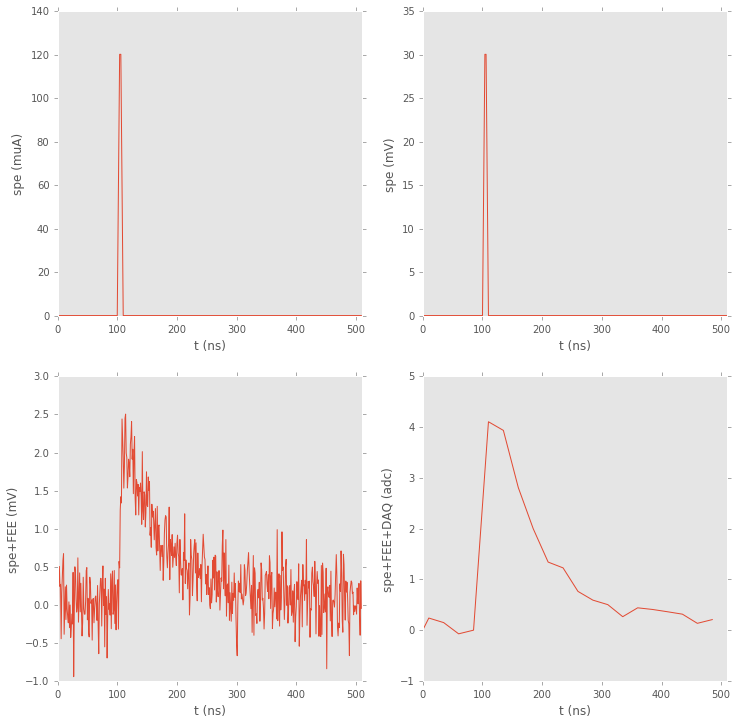

In [29]:
single_pe_blr()

In [32]:
def pulse_train(signal_start=2000*ns, signal_length=5000*ns, daq_window = 20*microsecond, noise=FP.NOISE_FEE_rms):
    signal_end = signal_start + signal_length
    spe = SP.SPE()
    fee = FEE()
    # PMT response to a photon train
    signal_t, signal_PE = spe.SpePulseTrain(signal_start,signal_end,daq_window)
    # spe in voltage (without FEE)
    signal_PE_v = fee.VSignal(signal_PE)
    #effect of FEE
    signal_fee = fee.FEESignal(signal_PE, noise_rms=noise)
    #effect of DAQ
    signal_t_daq, signal_daq = fee.DAQSignal(signal_t, signal_fee, noise_rms=0)
    #signal_daq *=FP.time_DAQ #re-scale by decimation factor
    plt.figure(figsize=(12,12))

    ax1 = plt.subplot(2,2,1)
    ax1.set_xlim([0, len(signal_t)])
    mpl.SetPlotLabels(xlabel='t (ns)', ylabel='spe train (muA)')
    plt.plot(signal_t, signal_PE/muA)

    ax2 = plt.subplot(2,2,2)
    ax2.set_xlim([0, len(signal_t)])
    mpl.SetPlotLabels(xlabel='t (ns)', ylabel='spe train (mV)')
    plt.plot(signal_t, signal_PE_v/mV)

    ax3 = plt.subplot(2,2,3)
    ax3.set_xlim([0, len(signal_t)])
    mpl.SetPlotLabels(xlabel='t (ns)', ylabel='spe+FEE (mV)')
    plt.plot(signal_t, signal_fee/mV)

    ax4 = plt.subplot(2,2,4)
    ax4.set_xlim([0, len(signal_t)])
    mpl.SetPlotLabels(xlabel='t (ns)', ylabel='spe+FEE+DAQ (adc)')
    plt.plot(signal_t_daq, signal_daq)

    area = np.sum(signal_daq)
    print("adc counts per spe = {}".format(area))

    plt.show()
    return signal_t, signal_fee




adc counts per spe = 35078.0749057


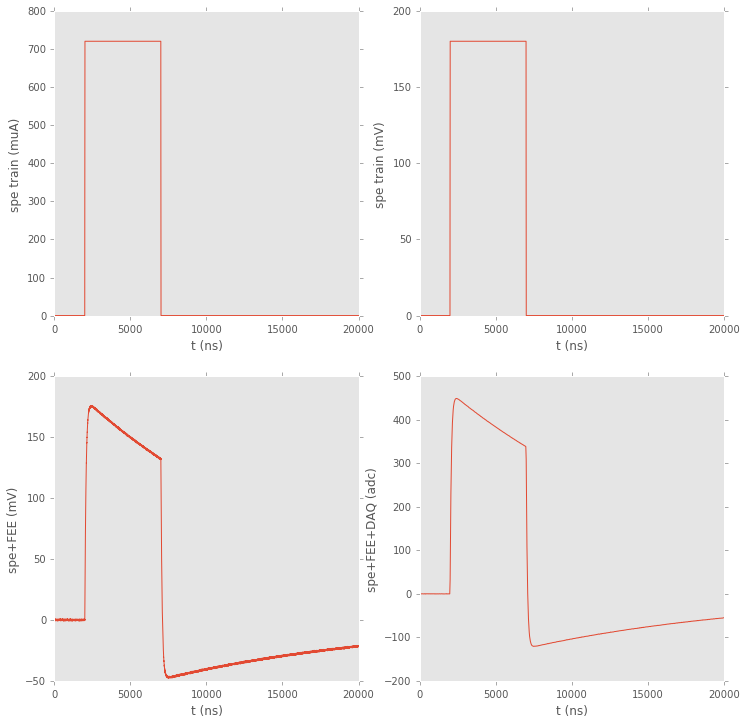

In [33]:
signal_t, signal_fee =pulse_train()

In [34]:
def pulse_train_blr(signal_start=2000*ns, signal_length=5000*ns, daq_window = 20*microsecond, noise=FP.NOISE_FEE_rms):
    signal_end = signal_start + signal_length
    spe = SP.SPE()
    fee = FEE()
    # PMT response to a photon train
    signal_t, signal_PE = spe.SpePulseTrain(signal_start,signal_end,daq_window)
    # spe in voltage (without FEE)
    signal_PE_v = fee.VSignal(signal_PE)
    #effect of FEE
    signal_fee = fee.BLRSignal(signal_PE, noise_rms=noise)
    #effect of DAQ
    signal_t_daq, signal_daq = fee.DAQSignal(signal_t, signal_fee, noise_rms=0)
    #signal_daq *=FP.time_DAQ #re-scale by decimation factor
    plt.figure(figsize=(12,12))

    ax1 = plt.subplot(2,2,1)
    ax1.set_xlim([0, len(signal_t)])
    mpl.SetPlotLabels(xlabel='t (ns)', ylabel='spe train (muA)')
    plt.plot(signal_t, signal_PE/muA)

    ax2 = plt.subplot(2,2,2)
    ax2.set_xlim([0, len(signal_t)])
    mpl.SetPlotLabels(xlabel='t (ns)', ylabel='spe train (mV)')
    plt.plot(signal_t, signal_PE_v/mV)

    ax3 = plt.subplot(2,2,3)
    ax3.set_xlim([0, len(signal_t)])
    mpl.SetPlotLabels(xlabel='t (ns)', ylabel='spe+FEE (mV)')
    plt.plot(signal_t, signal_fee/mV)

    ax4 = plt.subplot(2,2,4)
    ax4.set_xlim([0, len(signal_t)])
    mpl.SetPlotLabels(xlabel='t (ns)', ylabel='spe+FEE+DAQ (adc)')
    plt.plot(signal_t_daq, signal_daq)

    area = np.sum(signal_daq)
    print("adc counts per spe = {}".format(area))

    plt.show()
    return signal_t, signal_fee

adc counts per spe = 92306.7965067


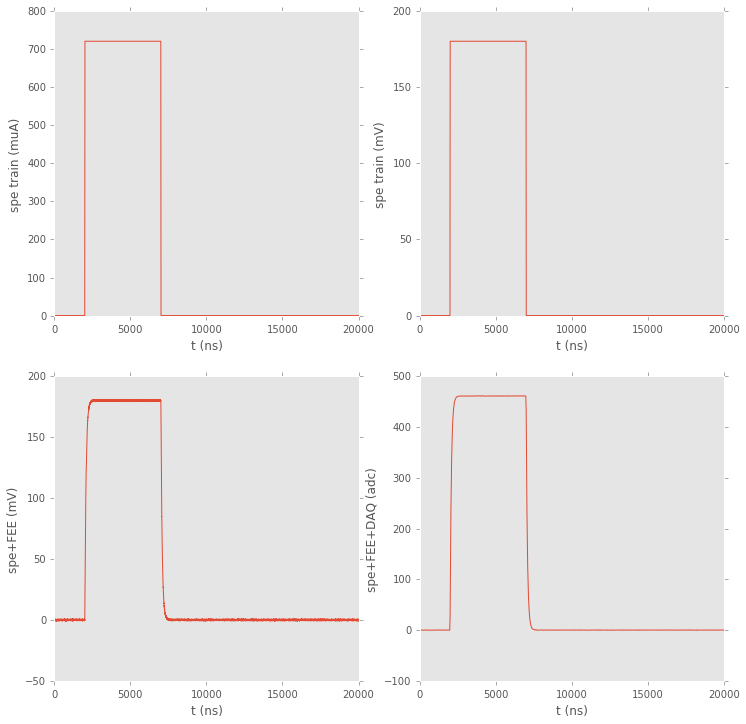

(array([  0.00000000e+00,   1.00000000e+00,   2.00000000e+00,
          3.00000000e+00,   4.00000000e+00,   5.00000000e+00,
          6.00000000e+00,   7.00000000e+00,   8.00000000e+00,
          9.00000000e+00,   1.00000000e+01,   1.10000000e+01,
          1.20000000e+01,   1.30000000e+01,   1.40000000e+01,
          1.50000000e+01,   1.60000000e+01,   1.70000000e+01,
          1.80000000e+01,   1.90000000e+01,   2.00000000e+01,
          2.10000000e+01,   2.20000000e+01,   2.30000000e+01,
          2.40000000e+01,   2.50000000e+01,   2.60000000e+01,
          2.70000000e+01,   2.80000000e+01,   2.90000000e+01,
          3.00000000e+01,   3.10000000e+01,   3.20000000e+01,
          3.30000000e+01,   3.40000000e+01,   3.50000000e+01,
          3.60000000e+01,   3.70000000e+01,   3.80000000e+01,
          3.90000000e+01,   4.00000000e+01,   4.10000000e+01,
          4.20000000e+01,   4.30000000e+01,   4.40000000e+01,
          4.50000000e+01,   4.60000000e+01,   4.70000000e+01,
        

In [35]:
pulse_train_blr()